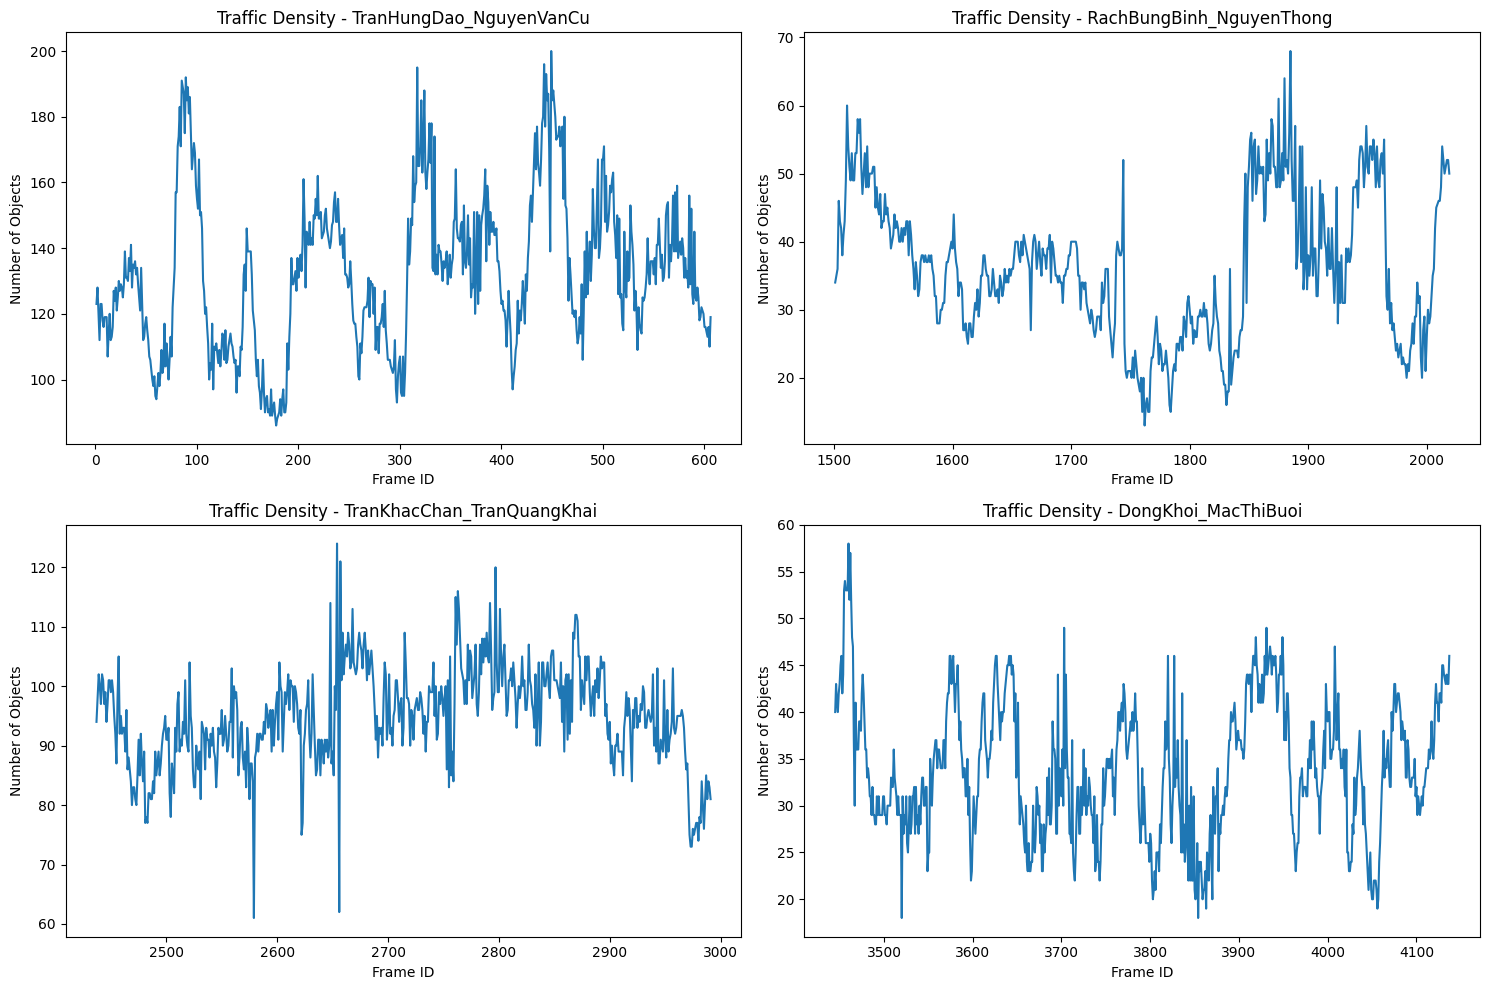

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
# Load and prepare data
label_dir = "/home/quannguyen/label-studio-ml-backend/yolo_finetune_datasets/labels"
label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.txt')],
                     key=lambda x: int(os.path.basename(x).split("_")[1].split(".")[0]))

data = []
for file in label_files:
    frame_id = int(os.path.basename(file).split("_")[1].split(".")[0])
    with open(file, 'r') as f:
        for line in f:
            class_id, *coords = line.strip().split()
            data.append([frame_id, int(class_id)] + list(map(float, coords)))

df = pd.DataFrame(data, columns=["frame_id", "class_id", "x_center", "y_center", "width", "height"])
class_names = {0: "motorbike", 1: "car", 2: "truck", 3: "bus", 4: "van", 5: "bicycle", 6: "pedestrian"}
df["class_name"] = df["class_id"].map(class_names)

video_ranges = {
    "TranHungDao_NguyenVanCu": (1, 606),
    "RachBungBinh_NguyenThong": (1501, 2019),
    "TranKhacChan_TranQuangKhai": (2437, 2991),
    "DongKhoi_MacThiBuoi": (3445, 4137)
}

video_dfs = [
    df[(df["frame_id"] >= start) & (df["frame_id"] <= end)]
    for (start, end) in video_ranges.values()
]
video_names = list(video_ranges.keys())

# 1. Traffic Density Comparison
plt.figure(figsize=(15, 10))
for i, (name, video_df) in enumerate(zip(video_names, video_dfs), 1):
    plt.subplot(2, 2, i)
    density = video_df.groupby("frame_id").size()
    plt.plot(density.index, density.values)
    plt.title(f"Traffic Density - {name}")
    plt.xlabel("Frame ID")
    plt.ylabel("Number of Objects")
plt.tight_layout()
plt.show()

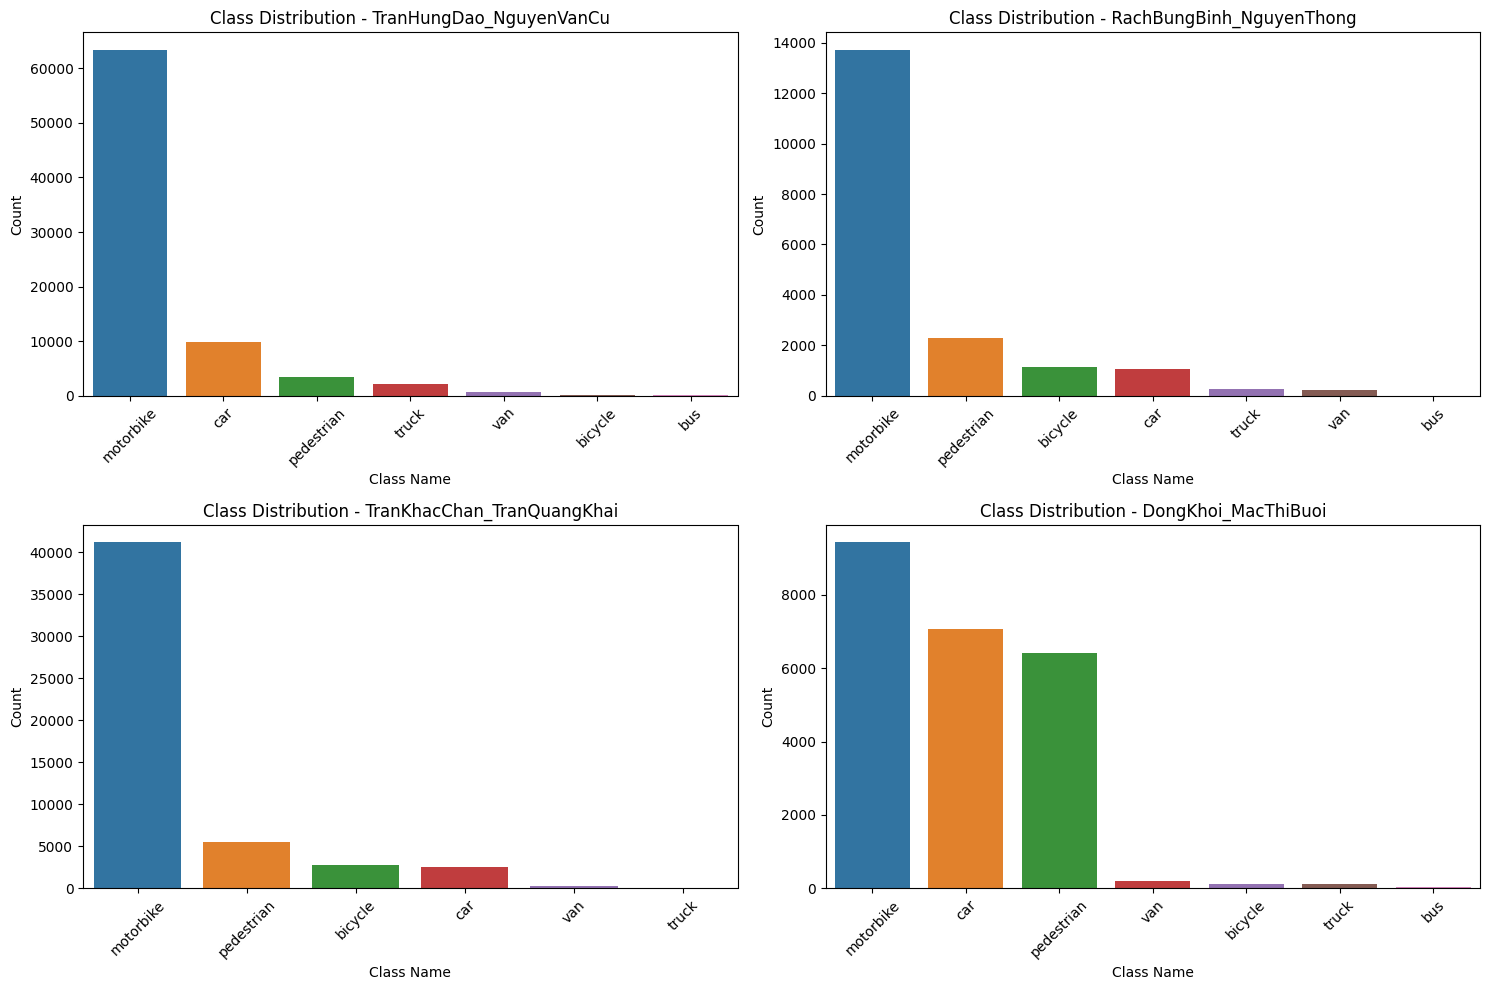

In [14]:
# 2. Class Distribution Comparison
plt.figure(figsize=(15, 10))

for i, (name, video_df) in enumerate(zip(video_names, video_dfs), 1):
    plt.subplot(2, 2, i)
    dist = video_df["class_name"].value_counts().reset_index()
    dist.columns = ["class_name", "count"]

    sns.barplot(
        data=dist,
        x="class_name",
        y="count",
        hue="class_name",
        palette="tab10",
        dodge=False
    )

    plt.title(f"Class Distribution - {name}")
    plt.xticks(rotation=45)
    plt.xlabel("Class Name")
    plt.ylabel("Count")
    plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

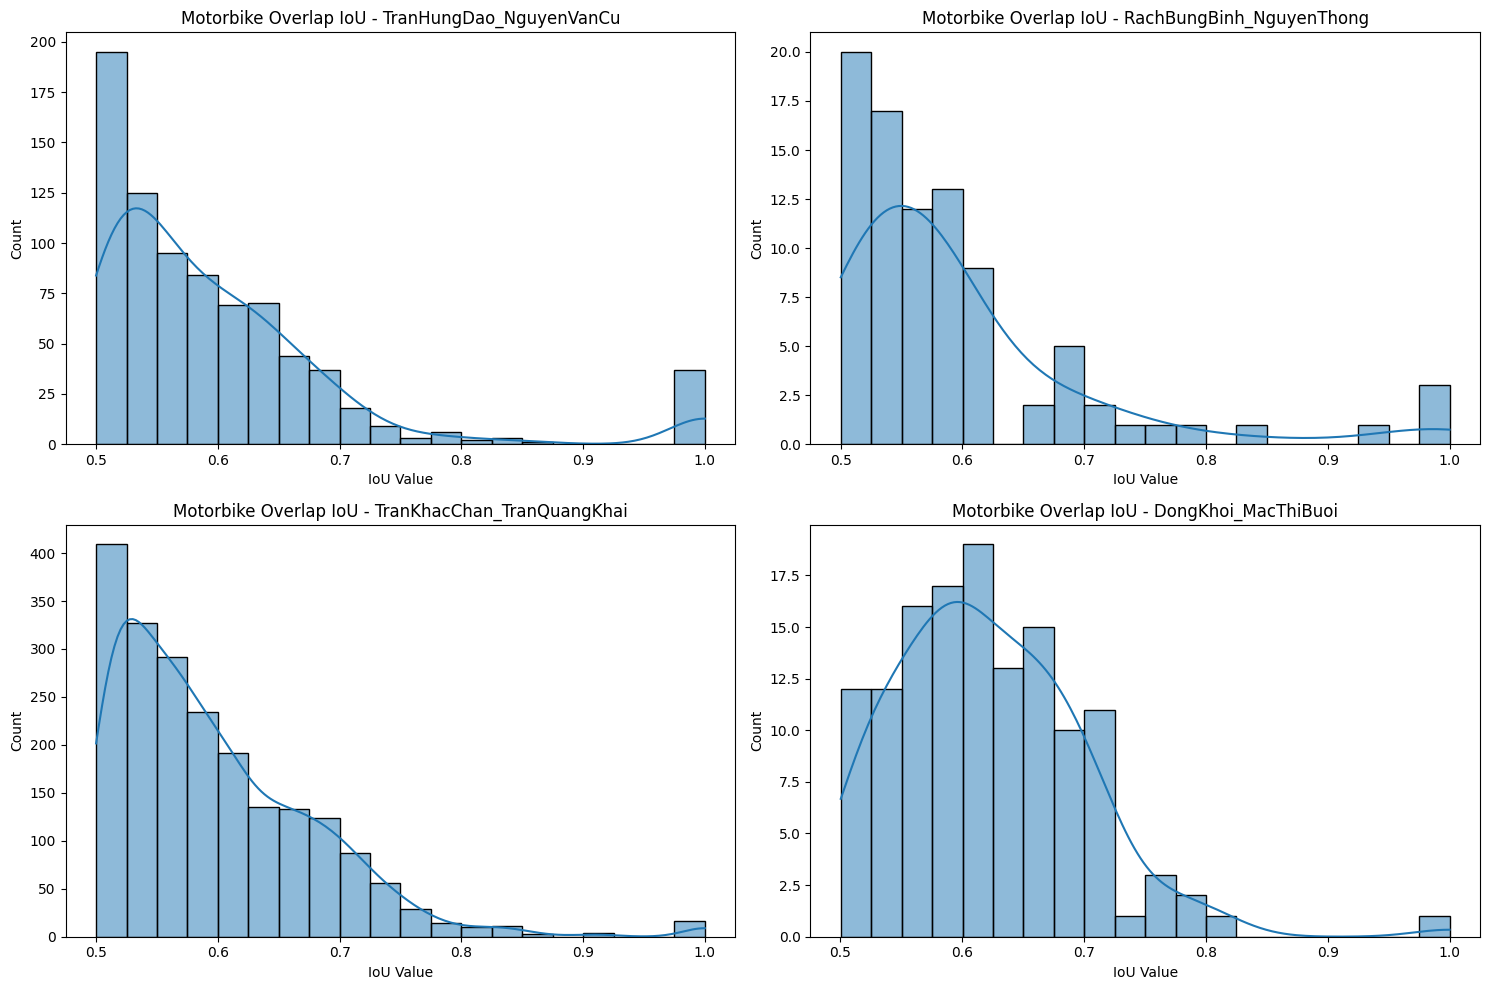

In [15]:
def calculate_iou(box1, box2):
    poly1 = Polygon([(box1[0], box1[1]), (box1[0] + box1[2], box1[1]), 
                     (box1[0] + box1[2], box1[1] + box1[3]), (box1[0], box1[1] + box1[3])])
    poly2 = Polygon([(box2[0], box2[1]), (box2[0] + box2[2], box2[1]), 
                     (box2[0] + box2[2], box2[1] + box2[3]), (box2[0], box2[1] + box2[3])])
    intersection = poly1.intersection(poly2).area
    union = poly1.union(poly2).area
    return intersection / union if union != 0 else 0

# 3. IoU Distribution Comparison
plt.figure(figsize=(15, 10))
for i, (name, video_df) in enumerate(zip(video_names, video_dfs), 1):
    plt.subplot(2, 2, i)
    motorbikes = video_df[video_df["class_name"] == "motorbike"]
    overlaps = []
    
    for _, frame in motorbikes.groupby("frame_id"):
        boxes = frame[["x_center", "y_center", "width", "height"]].values
        for i in range(len(boxes)):
            for j in range(i+1, len(boxes)):
                iou = calculate_iou(boxes[i], boxes[j])
                if iou > 0.5:
                    overlaps.append(iou)
    
    if overlaps:
        sns.histplot(overlaps, bins=20, kde=True)
    else:
        plt.text(0.5, 0.5, "No Overlaps", ha='center', va='center')
    plt.title(f"Motorbike Overlap IoU - {name}")
    plt.xlabel("IoU Value")
plt.tight_layout()
plt.show()

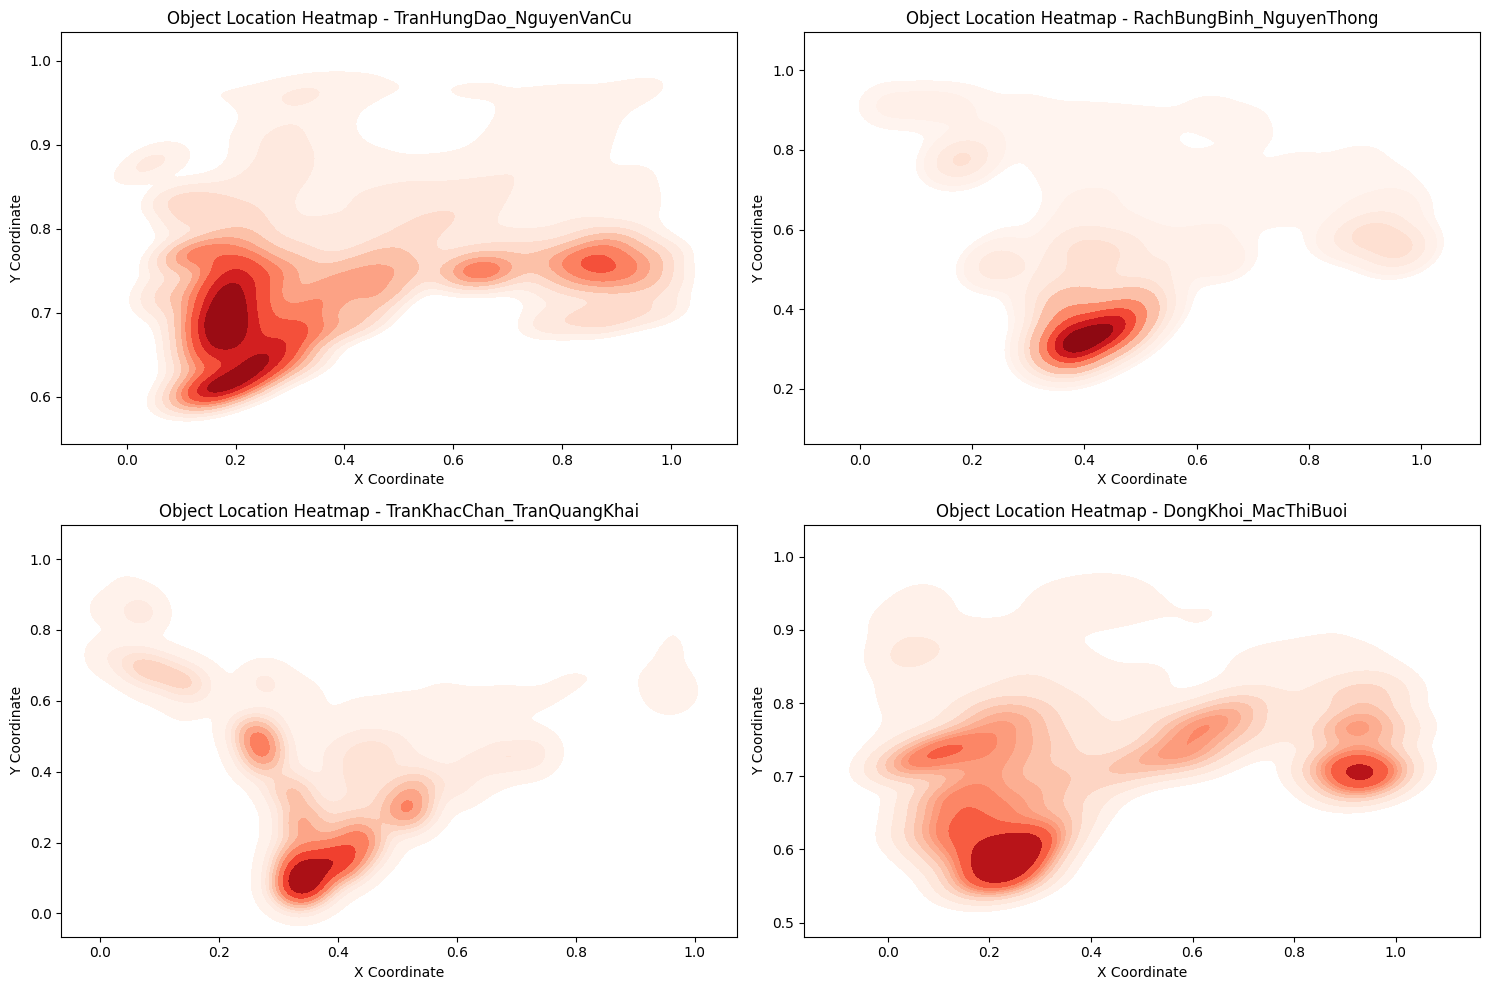

In [16]:
# 4. Location Heatmap Comparison
plt.figure(figsize=(15, 10))
for i, (name, video_df) in enumerate(zip(video_names, video_dfs), 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(x=video_df["x_center"], y=video_df["y_center"], 
                cmap="Reds", fill=True, thresh=0.05)
    plt.title(f"Object Location Heatmap - {name}")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
plt.tight_layout()
plt.show()

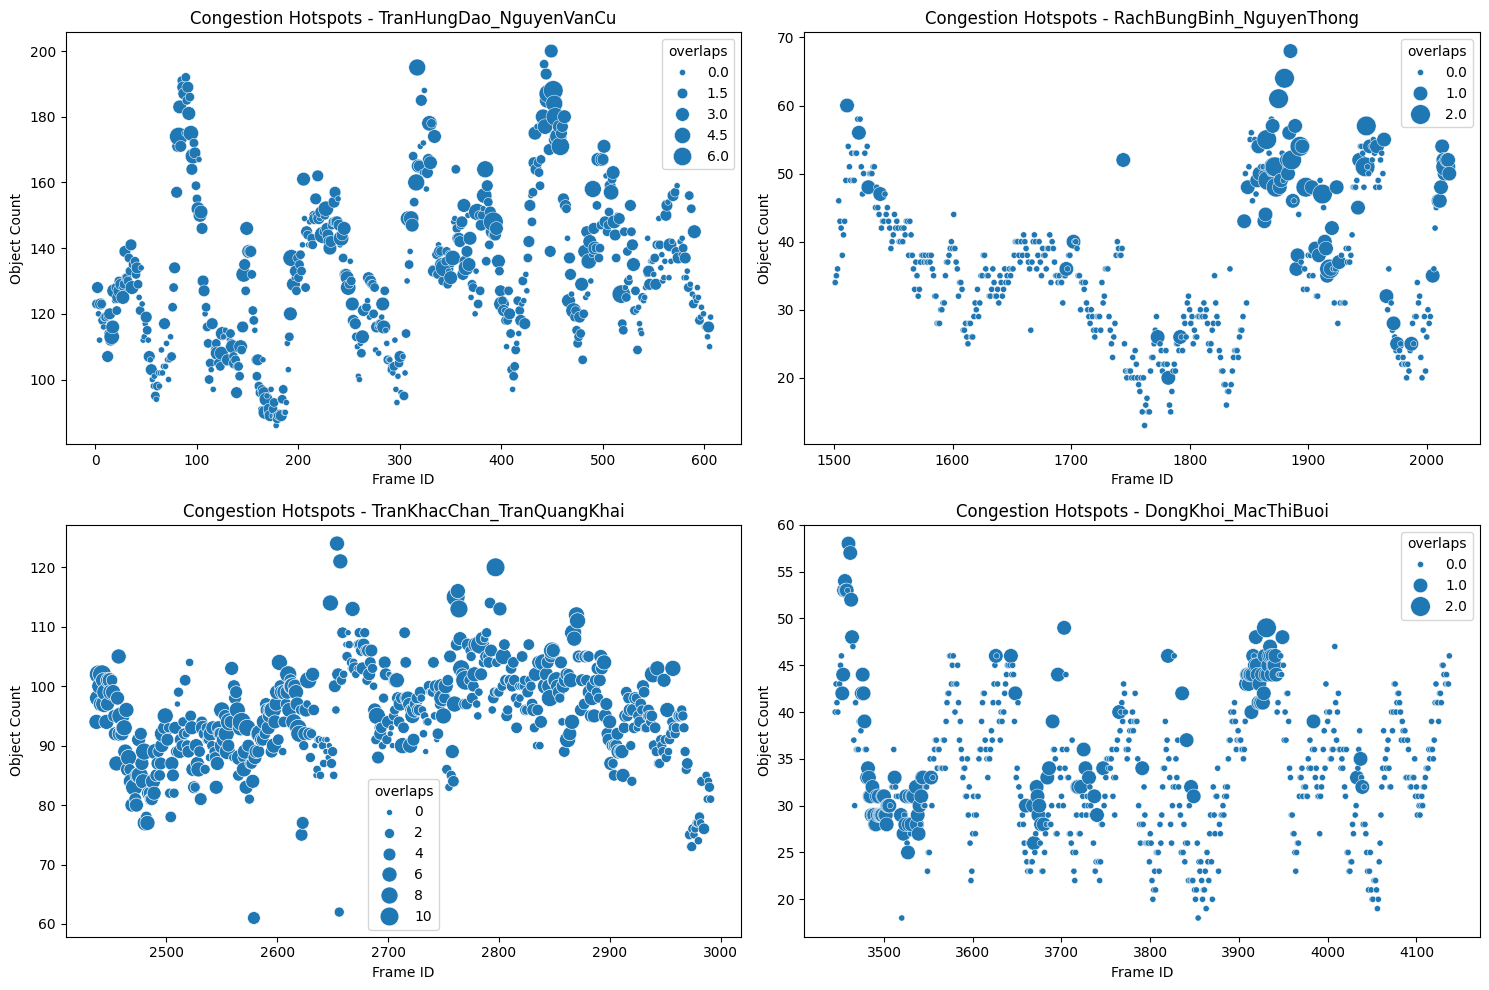

In [17]:
# 5. Congestion Hotspot Comparison
plt.figure(figsize=(15, 10))
for i, (name, video_df) in enumerate(zip(video_names, video_dfs), 1):
    plt.subplot(2, 2, i)
    
    # Calculate metrics
    density = video_df.groupby("frame_id").size().reset_index(name="count")
    motorbikes = video_df[video_df["class_name"] == "motorbike"]
    overlaps = []
    
    for frame_id, frame in motorbikes.groupby("frame_id"):
        boxes = frame[["x_center", "y_center", "width", "height"]].values
        for i in range(len(boxes)):
            for j in range(i+1, len(boxes)):
                if calculate_iou(boxes[i], boxes[j]) > 0.5:
                    overlaps.append(frame_id)
    
    overlap_counts = pd.Series(overlaps).value_counts().reset_index()
    overlap_counts.columns = ["frame_id", "overlaps"]
    
    merged = density.merge(overlap_counts, how="left", on="frame_id").fillna(0)
    
    sns.scatterplot(data=merged, x="frame_id", y="count", 
                    size="overlaps", sizes=(20, 200))
    plt.title(f"Congestion Hotspots - {name}")
    plt.xlabel("Frame ID")
    plt.ylabel("Object Count")
plt.tight_layout()
plt.show()